In [4]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re


from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import StackingClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve


In [5]:
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt_tab')

In [6]:
df = pd.read_csv('spam.csv', encoding="ISO-8859-1")
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [8]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [9]:
df.rename(columns={'v1': 'target', 'v2': 'email'}, inplace=True)
df.head()

,target,email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
print(df.isnull().sum())

target    0
email     0
dtype: int64


In [11]:
def clean_data(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ',', text)# remove punctuation
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)# remove URLs
    text = re.sub(r'\@\w+|\#','', text) # remove mentions and hashtags
    text = re.sub(r'\d+', '', text)  # remove numbers
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [12]:
df['email'] = df['email'].apply(clean_data)

In [13]:
df.head()

,target,email
0,ham,"go jurong point, crazy,, avail bugi n great wo..."
1,ham,"ok lar,,, joke wif u oni,,,"
2,spam,free entri wkli comp win fa cup final tkt st m...
3,ham,"u dun say earli hor,,, u c alreadi say,,,"
4,ham,"nah don,t think goe usf, live around though"


In [14]:
category_counts = df['target'].value_counts()
print(category_counts)

target
ham     4825
spam     747
Name: count, dtype: int64


In [15]:
mapper = {'ham': 0, 'spam': 1}
df['target'] = df['target'].map(mapper)
category_counts = df['target'].value_counts()
print(category_counts)

target
0    4825
1     747
Name: count, dtype: int64


In [16]:
df['num_characters'] = df['email'].apply(len)
df['num_words'] = df['email'].apply(lambda text: len(word_tokenize(text)))
df['num_sentences'] = df['email'].apply(lambda text: len(sent_tokenize(text)))

In [17]:
vectorizer = TfidfVectorizer()

X_text = vectorizer.fit_transform(df['email'])
X_features = df[['num_characters', 'num_words', 'num_sentences']].values
X = np.hstack((X_text.toarray(), X_features))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, df['target'], test_size=0.2, random_state=42)

In [38]:
# base_model = DecisionTreeClassifier(random_state=42)
base_model =  KNeighborsClassifier(n_neighbors= 6 )  
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)
base_accuracy = accuracy_score(y_test, y_pred_base)

In [21]:
base_models = [
    ('dt', DecisionTreeClassifier(random_state=42)),  # Decision Tree
    ('knn', KNeighborsClassifier(n_neighbors=5)),                 # KNN
    ('lr', LogisticRegression(max_iter=1000)),  # Logistic Regression
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),  # Random Forest   
    
    # ('svm', SVC(probability=True, kernel='linear', random_state=42))  # SVM
]

# Define the meta-learner (final model)
meta_learner = LogisticRegression()

# Create the Stacking model
stacking_model = StackingClassifier(
    estimators=base_models,  # Base models
    final_estimator=meta_learner,  # Meta model
    passthrough=False,  # Use original features + predictions from base models
    cv=5  # Cross-validation
)

# Train the Stacking model on the training data
stacking_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('dt', DecisionTreeClassifier(random_state=42)),
                               ('knn', KNeighborsClassifier()),
                               ('lr', LogisticRegression(max_iter=1000)),
                               ('rf',
                                RandomForestClassifier(n_estimators=50,
                                                       random_state=42))],
                   final_estimator=LogisticRegression())

In [55]:
xgb_model = XGBClassifier(
    n_estimators=100,   # Number of trees
    learning_rate=0.1,  # Step size shrinkage (controls impact of each tree)
    max_depth=4,        # Maximum depth of each tree
    random_state=42,
    use_label_encoder=True,
    eval_metric="mlogloss"  # Multi-class log loss
)

xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

In [25]:
Adaboost_model = AdaBoostClassifier(
    n_estimators=50,
    learning_rate=0.1,
    random_state=42
)
Adaboost_model.fit(X_train, y_train)

c:\Users\my\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(learning_rate=0.1, random_state=42)

In [27]:
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # Base model (Decision Tree)
    n_estimators=50,  # Number of estimators (trees)
    max_samples=0.8,  # Percentage of data used per model
    bootstrap=True,  # Enable bootstrapping (sampling with replacement)
    random_state=42
)

bagging_model.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=0.8,
                  n_estimators=50, random_state=42)

In [42]:
random_forest_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees 
    bootstrap=True,  # Enable bootstrapping (sampling with replacement)
    max_samples=0.8,  # Percentage of data used per model
    random_state=42
)
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.8, random_state=42)

In [43]:

y_pred_stacking = stacking_model.predict(X_test)

stacking_accuracy = accuracy_score(y_test, y_pred_stacking)


y_pred_xgb = xgb_model.predict(X_test)

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)


y_pred_bagging = bagging_model.predict(X_test)

bagging_accuracy = accuracy_score(y_test, y_pred_bagging)


y_pred_rf = random_forest_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred_rf)


y_pred_ada = Adaboost_model.predict(X_test)

ada_accuracy = accuracy_score(y_test, y_pred_ada)




In [52]:
print(f"📌 Accuracy of Base model: {base_accuracy:.4f}")
print(f"✅ Accuracy of Bagging : {bagging_accuracy:.4f}")
print(f"✅ Accuracy of Random Forest: {rf_accuracy:.4f}")
print(f"✅ Accuracy using XGBoost: {xgb_accuracy:.4f}")
print(f"✅ Accuracy of AdaBoost: {ada_accuracy:.4f}")
print(f"✅ Accuracy of Stacking (DT, KNN, rf + Logistic Regression): {stacking_accuracy:.4f}")




📌 Accuracy of Base model: 0.8843
✅ Accuracy of Bagging : 0.9686
✅ Accuracy of Random Forest: 0.9749
✅ Accuracy using XGBoost: 0.9677
✅ Accuracy of AdaBoost: 0.9336
✅ Accuracy of Stacking (DT, KNN, rf + Logistic Regression): 0.9821


AUC-ROC (XGBoost): 0.9726321243523317
AUC-ROC (Stacking): 0.9852020725388602
AUC-ROC (Bagging): 0.9700207253886011
AUC-ROC (Random Forest): 0.9837098445595855
AUC-ROC (AdaBoost): 0.943474956822107


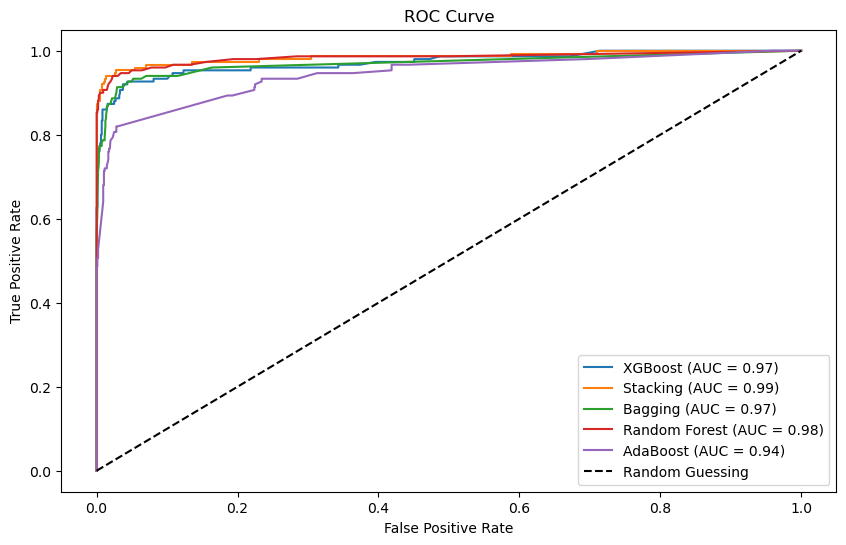

In [45]:
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]
print("AUC-ROC (XGBoost):", roc_auc_score(y_test, y_prob_xgb))
y_prob_stacking = stacking_model.predict_proba(X_test)[:,1]
print("AUC-ROC (Stacking):", roc_auc_score(y_test, y_prob_stacking))
y_prob_bagging = bagging_model.predict_proba(X_test)[:,1]
print("AUC-ROC (Bagging):", roc_auc_score(y_test, y_prob_bagging))
y_prob_rf = random_forest_model.predict_proba(X_test)[:,1]
print("AUC-ROC (Random Forest):", roc_auc_score(y_test, y_prob_rf))
y_prob_ada = Adaboost_model.predict_proba(X_test)[:,1]
print("AUC-ROC (AdaBoost):", roc_auc_score(y_test, y_prob_ada))
# Plotting ROC Curve
plt.figure(figsize=(10, 6))
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_stacking, tpr_stacking, _ = roc_curve(y_test, y_prob_stacking)
fpr_bagging, tpr_bagging, _ = roc_curve(y_test, y_prob_bagging)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_prob_ada)

plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_xgb)))
plt.plot(fpr_stacking, tpr_stacking, label='Stacking (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_stacking)))
plt.plot(fpr_bagging, tpr_bagging, label='Bagging (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_bagging)))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_rf)))
plt.plot(fpr_ada, tpr_ada, label='AdaBoost (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_ada)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

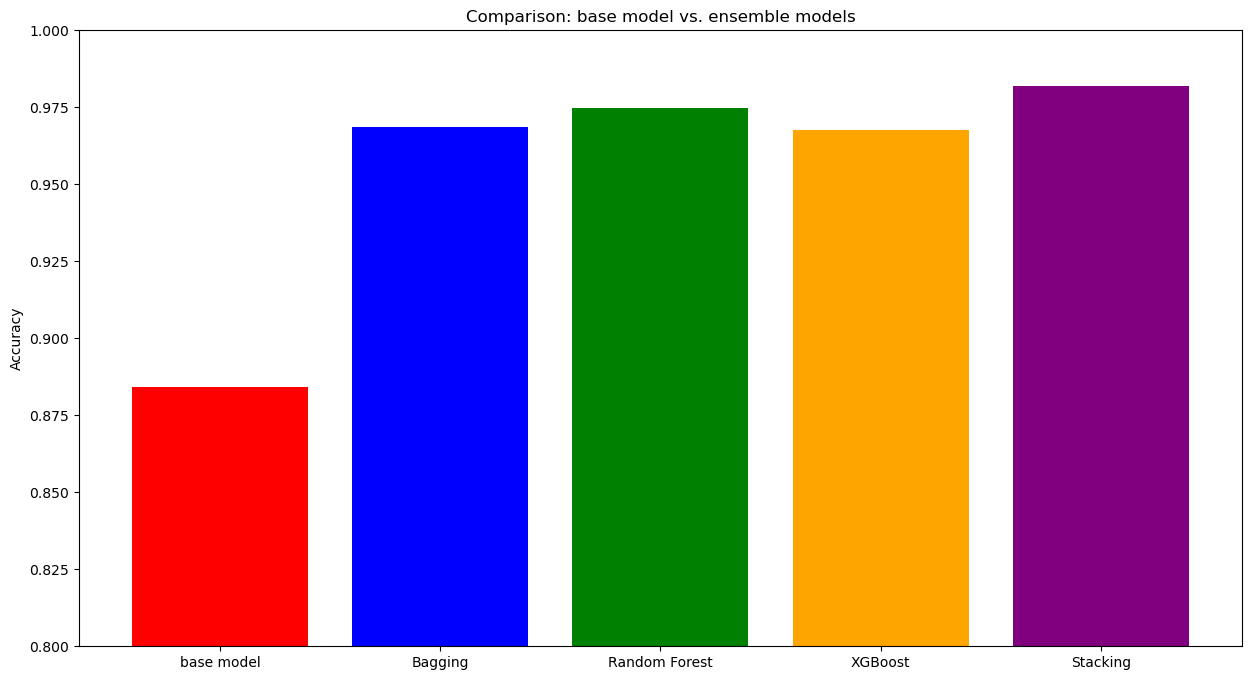

In [46]:
labels = ['base model', 'Bagging','Random Forest', 'XGBoost', 'Stacking']
accuracies = [base_accuracy, bagging_accuracy, rf_accuracy, xgb_accuracy, stacking_accuracy] 
plt.figure(figsize=(15, 8))
plt.bar(labels, accuracies, color=['red', 'blue', 'green', 'orange', 'purple'])
plt.ylabel('Accuracy')
plt.title('Comparison: base model vs. ensemble models')
plt.ylim(0.8, 1)  # Adjust scale
plt.show()

Classification Report (Base model):
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       965
           1       0.62      0.37      0.46       150

    accuracy                           0.88      1115
   macro avg       0.76      0.67      0.70      1115
weighted avg       0.87      0.88      0.87      1115



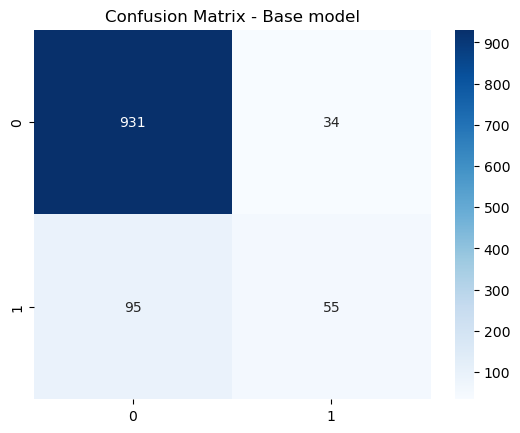

In [47]:
print("Classification Report (Base model):")
print(classification_report(y_test, y_pred_base))
sns.heatmap(confusion_matrix(y_test, y_pred_base), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Base model")
plt.show()


Classification Report (Stacking):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.88      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



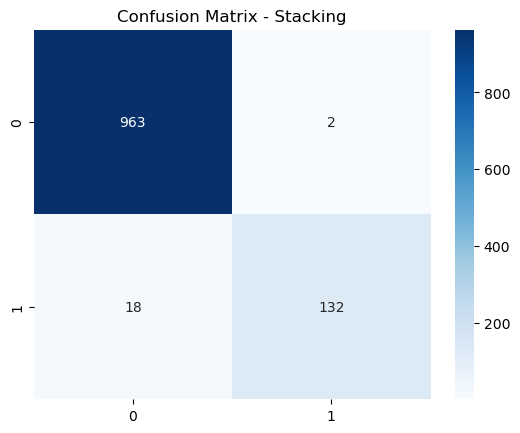

In [48]:
print("Classification Report (Stacking):")
print(classification_report(y_test, y_pred_stacking))
sns.heatmap(confusion_matrix(y_test, y_pred_stacking), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Stacking")
plt.show()


Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       965
           1       0.95      0.81      0.87       150

    accuracy                           0.97      1115
   macro avg       0.96      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



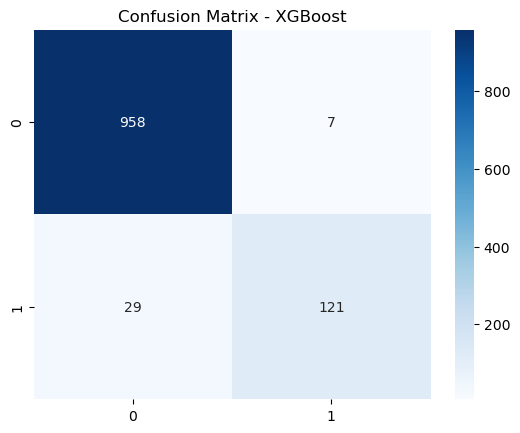

In [49]:
print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()

Classification Report (Bagging):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       965
           1       0.90      0.86      0.88       150

    accuracy                           0.97      1115
   macro avg       0.94      0.92      0.93      1115
weighted avg       0.97      0.97      0.97      1115



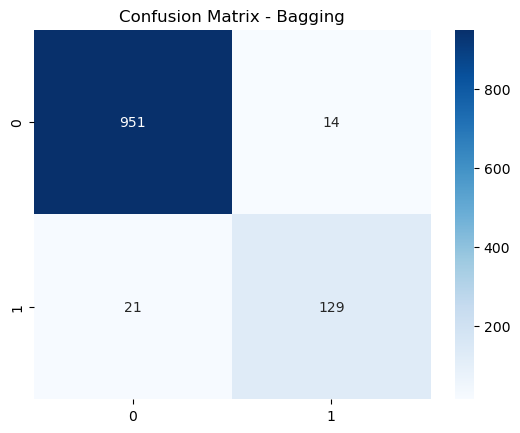

In [50]:
print("Classification Report (Bagging):")
print(classification_report(y_test, y_pred_bagging))
sns.heatmap(confusion_matrix(y_test, y_pred_bagging), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Bagging")
plt.show()

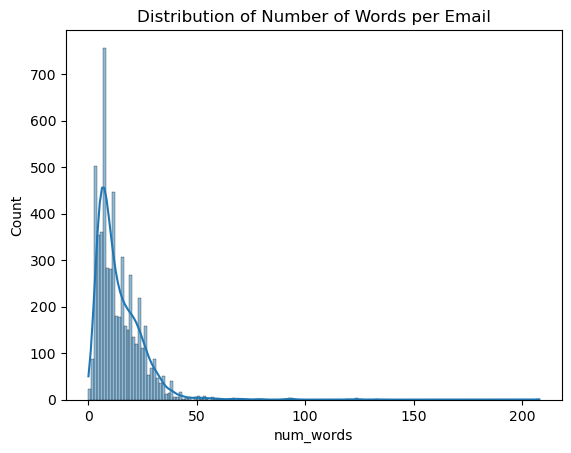

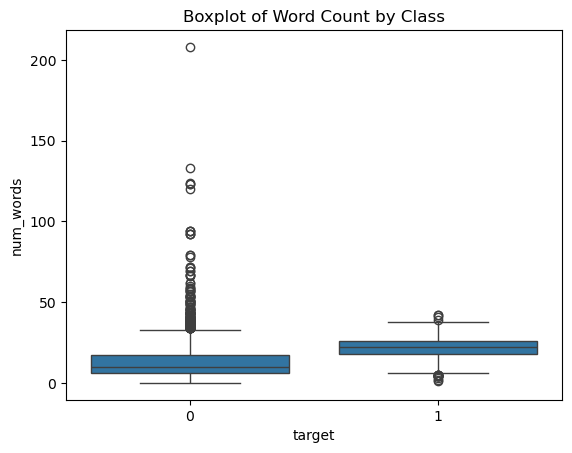

In [56]:
sns.histplot(df['num_words'], kde=True)
plt.title("Distribution of Number of Words per Email")
plt.show()

sns.boxplot(x='target', y='num_words', data=df)
plt.title("Boxplot of Word Count by Class")
plt.show()

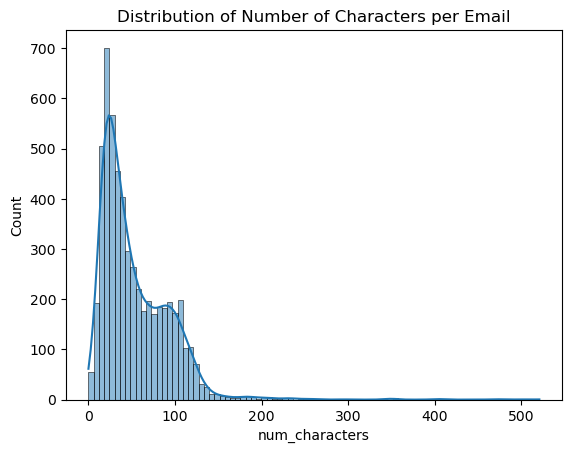

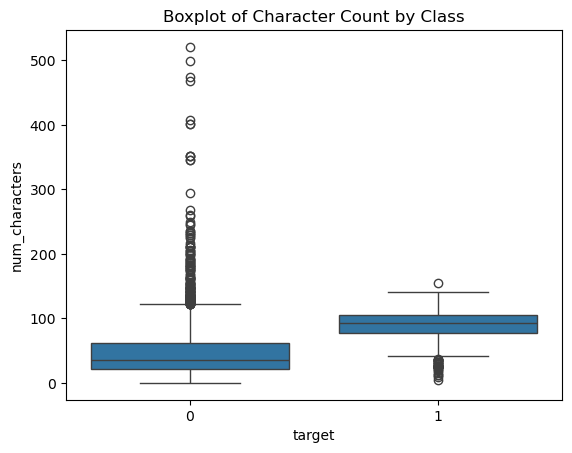

In [58]:
sns.histplot(df['num_characters'], kde=True)
plt.title("Distribution of Number of Characters per Email")
plt.show()

sns.boxplot(x='target', y='num_characters', data=df)
plt.title("Boxplot of Character Count by Class")
plt.show()